In [6]:

import warnings
warnings.filterwarnings('ignore')
from io import StringIO
from collections import OrderedDict
from itertools import combinations

# scientific packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy as pt
from scipy import optimize
from scipy.stats import norm, laplace, ks_2samp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.manifold import TSNE
import statsmodels.api as sm
from time import time
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm 

from scipy.optimize import fmin_powell
from scipy import integrate
pd.set_option("display.max_rows",30)
import theano as thno
import theano.tensor as T 


In [7]:
def run_models(df, upper_order=5):
    ''' 
    Convenience function:
    Fit a range of pymc3 models of increasing polynomial complexity. 
    Suggest limit to max order 5 since calculation time is exponential.
    '''

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1,upper_order+1):

        nm = 'k{}'.format(k)
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print('\nRunning: {}'.format(nm))
            pm.glm.glm(fml, df, family=pm.glm.families.Normal())

            start_MAP = pm.find_MAP(fmin=fmin_powell)
            traces[nm] = pm.sample(2000, start=start_MAP, step=pm.NUTS(), progressbar=True) 

    return models, traces

def plot_traces(traces, retain=1000):
    ''' 
    Convenience function:
    Plot traces with overlaid means and values
    '''

    ax = pm.traceplot(traces[-retain:], figsize=(12,len(traces.varnames)*1.5),
        lines={k: v['mean'] for k, v in pm.df_summary(traces[-retain:]).iterrows()})

    for i, mn in enumerate(pm.df_summary(traces[-retain:])['mean']):
        ax[i,0].annotate('{:.2f}'.format(mn), xy=(mn,0), xycoords='data'
                    ,xytext=(5,10), textcoords='offset points', rotation=90
                    ,va='bottom', fontsize='large', color='#AA0022')

def create_poly_modelspec(k=1):
    ''' 
    Convenience function:
    Create a polynomial modelspec string for patsy
    '''
    return ('income ~ educ + hours + age ' + ' '.join(['+ np.power(age,{})'.format(j) 
                                     for j in range(2,k+1)])).strip()

# Some Bayesian AB testing. 
* Thanks to my overly talented friend Maciej Kula for this example. 
* We'll reproduce some of his work from a blog post, and learn how to do AB testing with PyMC3. 

In [8]:
def generate_data(no_samples,
                  treatment_proportion=0.1,
                  treatment_mu=1.2,
                  control_mu=1.0,
                  sigma=0.4):
    """
    Generate sample data from the experiment.
    """

    rnd = np.random.RandomState(seed=12345)

    treatment = rnd.binomial(1, treatment_proportion, size=no_samples)
    treatment_outcome = rnd.normal(treatment_mu, sigma, size=no_samples)
    control_outcome = rnd.normal(control_mu, sigma, size=no_samples)
    observed_outcome = (treatment * treatment_outcome + (1 - treatment) * control_outcome)

    return pd.DataFrame({'treatment': treatment, 'outcome': observed_outcome})

In [9]:
def fit_uniform_priors(data):
    """
    Fit the data with uniform priors on mu.
    """

    # Theano doesn't seem to work unless we
    # pull this out into a normal numpy array.
    treatment = data['treatment'].values

    with pm.Model() as model:
        prior_mu=0.01
        prior_sigma=0.001
        treatment_sigma=0.001
        
        control_mean = pm.Normal('Control mean',
                                 prior_mu,
                                 sd=prior_sigma)
        # Specify priors for the difference in means
        treatment_effect = pm.Normal('Treatment effect',
                                     0.0,
                                     sd=treatment_sigma)
        # Recover the treatment mean
        treatment_mean = pm.Deterministic('Treatment mean',
                                          control_mean
                                          + treatment_effect)
        

        
        # Specify prior for sigma
        sigma = pm.InverseGamma('Sigma',
                                0.001,
                                1.1)
        # Data model
        outcome = pm.Normal('Outcome',
                            control_mean
                            + treatment * treatment_effect,
                            sd=sigma, observed=data['outcome'])


        # Fit
        samples = 5000
        start = pm.find_MAP()
        step = pm.Metropolis()
        trace = pm.sample(samples, step, start, njobs=3)

        # Discard burn-in
        trace = trace[int(samples * 0.5):]

        return pm.trace_to_dataframe(trace)

In [10]:
data = generate_data(1000)
fit_uniform_priors(data).describe()

Applied log-transform to Sigma and added transformed Sigma_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 2.7 sec

,Control mean,Treatment effect,Sigma,Treatment mean,Sigma_log
count,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,0.010839,0.000098,1.097155,0.010937,0.092471
std,0.001012,0.000989,0.024524,0.001413,0.022336
min,0.007057,-0.003501,0.997664,0.004966,-0.002338
25%,0.010132,-0.000563,1.080225,0.009971,0.077170
50%,0.010864,0.000095,1.096706,0.010918,0.092311
75%,0.011547,0.000765,1.113764,0.011920,0.107745
max,0.014356,0.003740,1.204540,0.016084,0.186098


So we have a small treatment effect, but some of the results are negative. 
* **Observations** No model is perfect even a bayesian method.  
* We probably have misspecificed one of our priors here. 
* An in-depth discussion of this is offered on the [Lyst blog](http://developers.lyst.com/2014/09/04/testing-continuous-variables/) which is well worth a read.
* When model evaluating you need to be very careful and think long and hard about what the results mean. 
* Model evaluation is a very hard problem, and even after several years of doing data science I personally find this very hard. 


# Hypothesis testing. 
* How do you test a hypothesis in Python?
* Examples shamelessly stolen from [Chris Albon](http://chrisalbon.com/). 


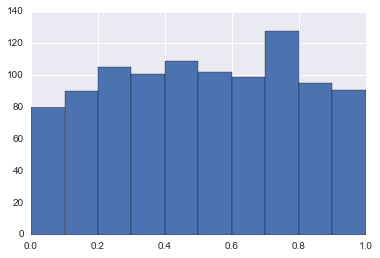

In [11]:
# Create x, which is uniformly distributed
x = np.random.uniform(size=1000)

# Plot x to double check its distribution
plt.hist(x)
plt.show()

Now we want to create another distribution which is not uniformly distributed. We'll then apply a test to this, to tell the difference. 

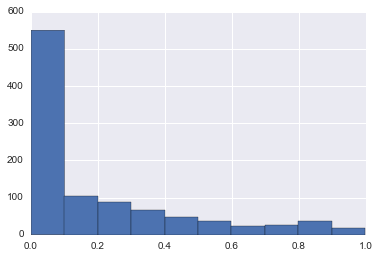

In [12]:
# Create y, which is NOT uniformly distributed
y = x**4

# Plot y to double check its distribution
plt.hist(y)
plt.show()

In [13]:
# Run kstest on x. We want the second returned value to be 
# not statistically significant, meaning that both come from 
# the same distribution.
from scipy import stats
stats.kstest(x, 'uniform', args=(min(x),max(x)))

KstestResult(statistic=0.036393234700046614, pvalue=0.13803494576248587)

We see that the p-value is greater than 0.5 
therefore we can say that this is not statistically significant, meaning both come from the same distribution

# Why do we use the Kolmogorov-Smirnov test? 
* Nonparametric so makes no assumptions about the distributions. 
* There are other tests which we could use. 

In [14]:
stats.kstest(y, 'uniform', args=(min(x),max(x)))

KstestResult(statistic=0.46204465826301938, pvalue=0.0)

We see that the p-value is less than 0.5, therefore we can say that this is statistically significant, meaning that y is not a uniform distribution. 

If you do A/B testing professionally, or work in say Pharma - you can spend a lot of time doing examples like this. 

# T-tests 
* t-tests - what are these or 'I hated stats at school too so I forgot all of this'
* We'll use one of the t-tests from Scipy. 
* We expect the variances to be different from these two distributions. 

In [15]:
stats.ttest_ind(x, y, equal_var = False)

Ttest_indResult(statistic=26.068815138324439, pvalue=4.2915543507844923e-129)

# Is there a Bayesian way to do this? 
* Or 'Peadar aren't you famous for being a Bayesian'?
* Yes there is, there is a BEST (Bayesian Estimation Superseeds the t-test). 
* We'll use this. 

In [16]:
"""Bayesian Estimation Supersedes the T-Test

This model replicates the example used in:
Kruschke, John. (2012) Bayesian estimation supersedes the t test. Journal of Experimental Psychology: General.

The original pymc2 implementation was written by Andrew Straw and can be found here: https://github.com/strawlab/best

Ported to PyMC3 by Thomas Wiecki (c) 2015. 
(Slightly altered version for this tutorial by Peadar Coyle (c) 2016)
"""

import numpy as np
import pymc3 as pm



y1 = np.random.uniform(size=1000)
y2 = (np.random.uniform(size=1000)) ** 4
y = np.concatenate((y1, y2))

mu_m = np.mean( y )
mu_p = 0.000001 * 1/np.std(y)**2

sigma_low = np.std(y)/1000
sigma_high = np.std(y)*1000

with pm.Model() as model:
    group1_mean = pm.Normal('group1_mean', mu=mu_m, tau=mu_p, testval=y1.mean())
    group2_mean = pm.Normal('group2_mean', mu=mu_m, tau=mu_p, testval=y2.mean())
    group1_std = pm.Uniform('group1_std', lower=sigma_low, upper=sigma_high, testval=y1.std())
    group2_std = pm.Uniform('group2_std', lower=sigma_low, upper=sigma_high, testval=y2.std())
    nu = pm.Exponential('nu_minus_one', 1/29.) + 1

    lam1 = group1_std**-2
    lam2 = group2_std**-2

    group1 = pm.StudentT('drug', nu=nu, mu=group1_mean, lam=lam1, observed=y1)
    group2 = pm.StudentT('placebo', nu=nu, mu=group2_mean, lam=lam2, observed=y2)

    diff_of_means = pm.Deterministic('difference of means', group1_mean - group2_mean)
    diff_of_stds = pm.Deterministic('difference of stds', group1_std - group2_std)
    effect_size = pm.Deterministic('effect size', diff_of_means / pm.sqrt((group1_std**2 + group2_std**2) / 2))

    step = pm.NUTS()
    trace = pm.sample(5000, step)

Applied interval-transform to group1_std and added transformed group1_std_interval to model.
Applied interval-transform to group2_std and added transformed group2_std_interval to model.
Applied log-transform to nu_minus_one and added transformed nu_minus_one_log to model.
 [-----------------100%-----------------] 5000 of 5000 complete in 30.5 sec

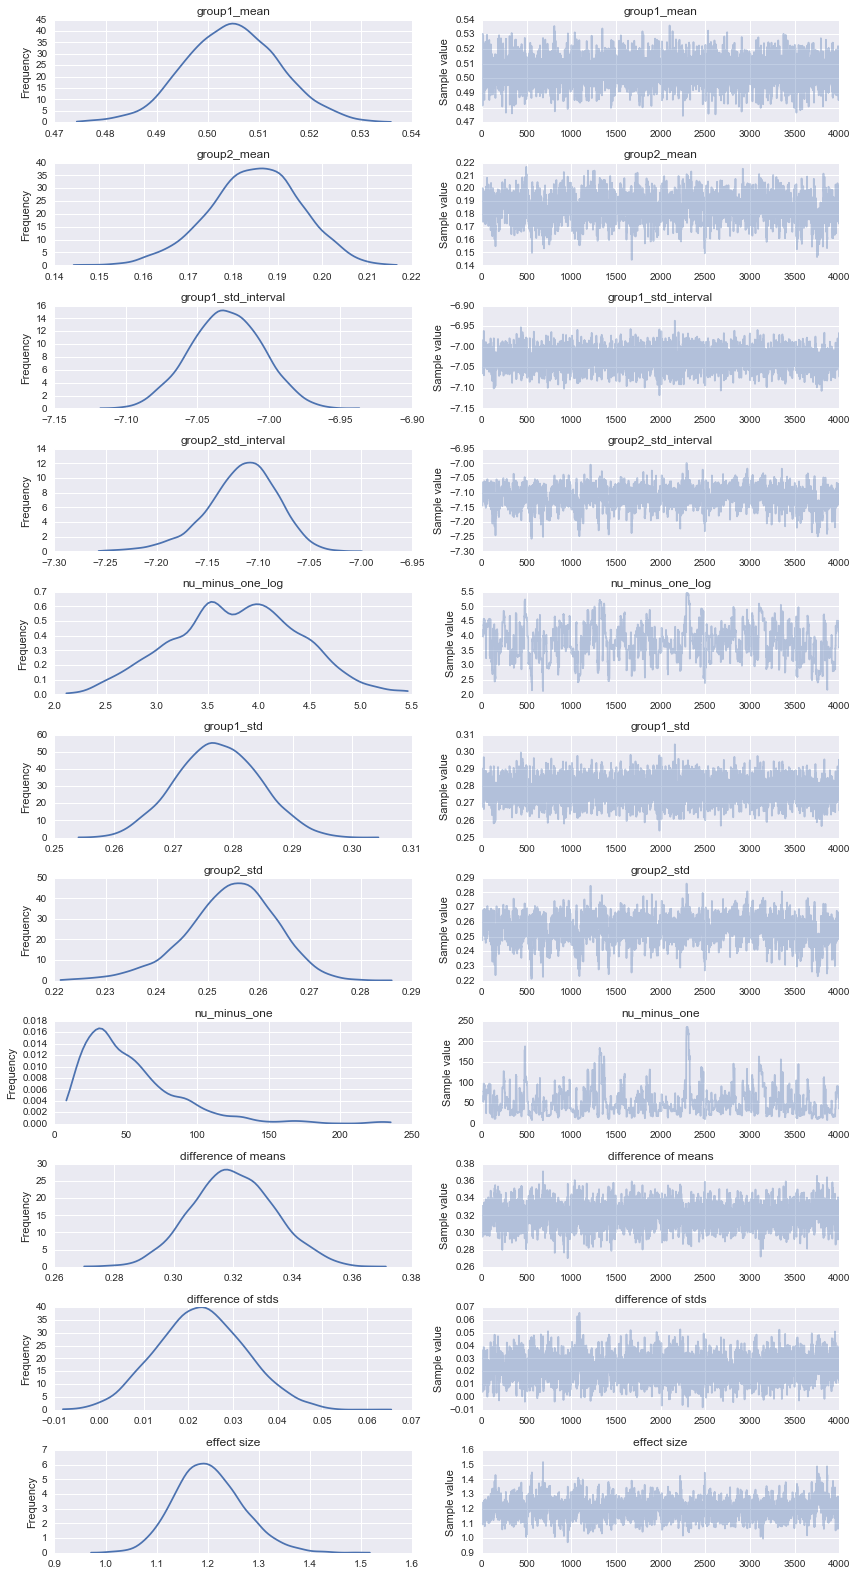

In [17]:
pm.traceplot(trace[1000:]);

* We see pretty good convergence here, the sampler worked quite well. 
* Using Jon Sedars plotting functions we can see slightly better plots. 

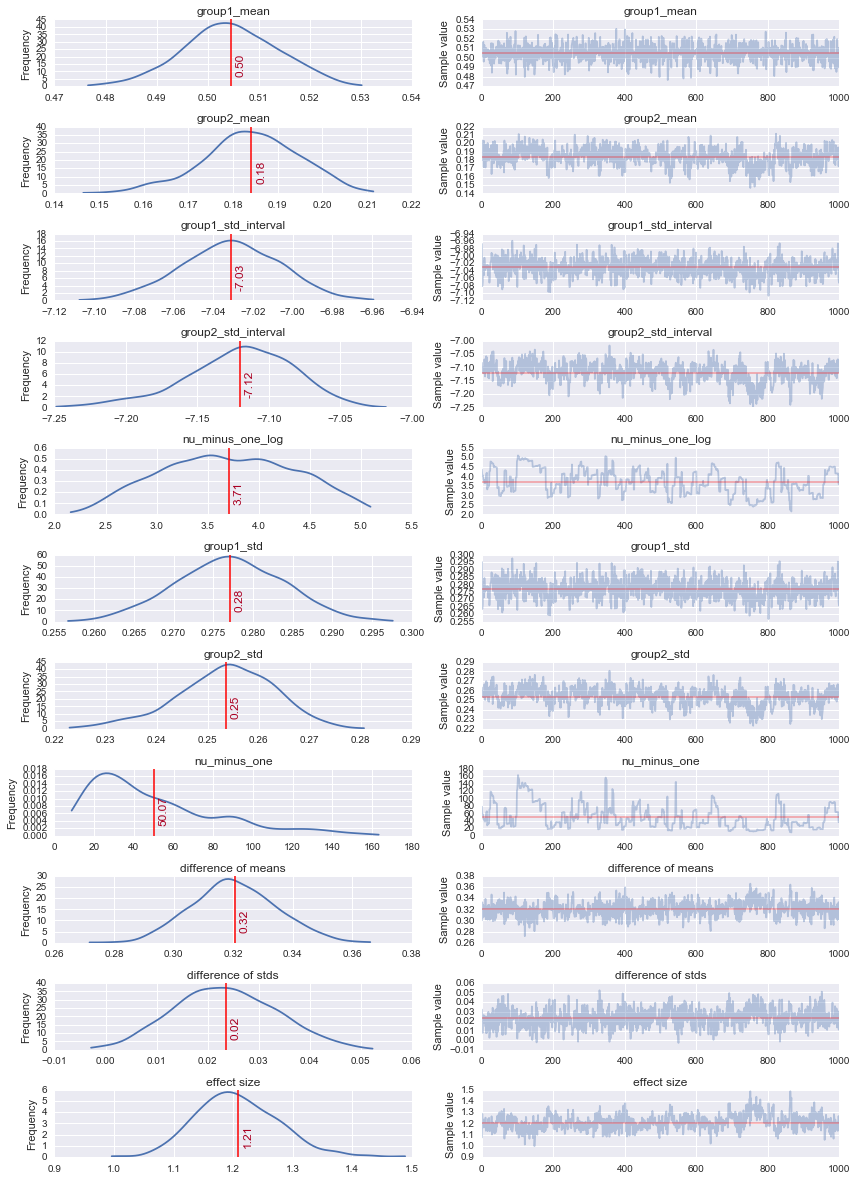

In [18]:
plot_traces(trace, retain=1000)


* Let us plot the autocorrelation plot. 


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12b6226d8>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x12c0d6e48>]], dtype=object)

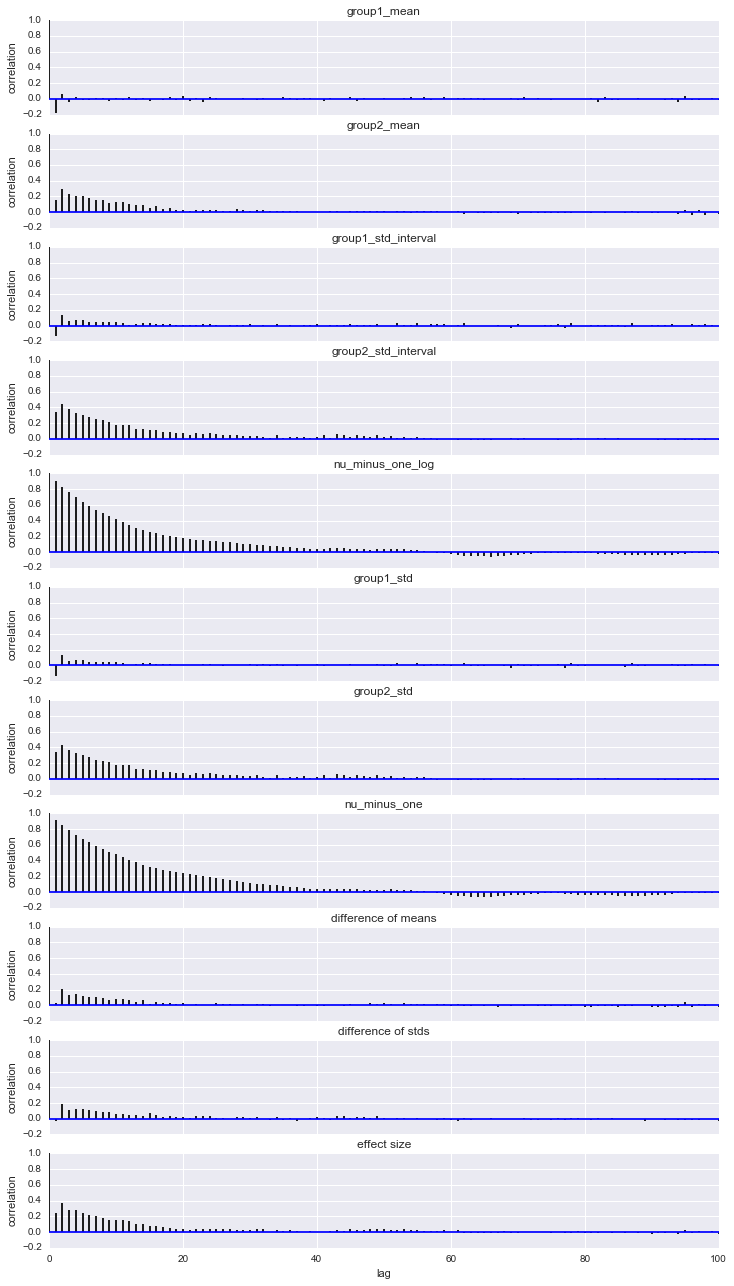

In [19]:
pm.autocorrplot(trace)

* Most of these plots look good except the nu minus one one. 
* The rest decay quite quickly, indicating not much autocorrelation. 
* We'll move on from this now but we should be aware that this model isn't well specified. 

# Logistic regression. 
* We're now going to get to the meat of the tutorial, we'll look at Logistic regression models in ML, Bayesian and Frequentists. 
* We'll do some comparisons and stuff like this. 

In [20]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data", header=None, names=['age', 'workclass', 'fnlwgt', 
                'education-categorical', 'educ', 
                'marital-status', 'occupation',
                'relationship', 'race', 'sex', 
                'captial-gain', 'capital-loss', 
                'hours', 'native-country', 
                'income'])

CertificateError: hostname 'archive.ics.uci.edu' doesn't match either of 'btopenzone.com', 'www.btwifi.co.uk', 'reg.btwifi.com', 'info.btopenzone.com', 'cdn.btwifi.com', 'btwifi.com', 'btwifi.co.uk', 'www.btopenzone.com', 'my.btwifi.com', 'my.btopenzone.com', 'info.btwifi.com', 'www.btwifi.com'

In [ ]:
data

* We want to remove the nulls from this data set. 
* And then we want to filter by only in the United States. 

In [ ]:
data = data[~pd.isnull(data['income'])]

In [ ]:
data[data['native-country']==" United-States"]

# Feature engineering or picking the covariates. 
* We want to restrict this study to just some of the variables. Our aim will be to predict if someone earns more than 50K or not. 

* We'll do a bit of exploring of the data first.

In [ ]:
income = 1 * (data['income'] == " >50K")
age2 = np.square(data['age'])

In [ ]:
data = data[['age', 'educ', 'hours']]
data['age2'] = age2
data['income'] = income

In [ ]:
income.value_counts()

# Exploring the data
Let us get a feel for the parameters. 
* We see that age is a tailed distribution. 
* Certainly not Gaussian! We don't see much of a correlation between many of the features, with the exception of Age and Age2.
* Hours worked has some interesting behaviour. How would one describe this distribution?

In [ ]:
import seaborn as seaborn
g = seaborn.pairplot(data)

In [ ]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = seaborn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
seaborn.heatmap(corr, mask=mask, cmap=cmap, vmax=.3,
            linewidths=.5, cbar_kws={"shrink": .5}, ax=ax)

# A frequentist model 
Let's look at a simple frequentist model

In [ ]:
train_cols = [col for col in data.columns if col not in ['income']]


In [ ]:


logit = sm.Logit(data['income'], data[train_cols])

# fit the model
result = logit.fit()

In statsmodels the thing we are trying to predict comes fist. 
This confused me when writing this :) 

In [ ]:
train_cols

In [ ]:
result.summary()

# Observations
In this case the McFaddens Pseudo R Squared (there are other variants) is slightly positive but not strongly positive. 

One rule of thumb is that if it is between 0.2 and 0.4 this is a good model fit. 
This is a bit below this, but still small, so we can interpret this as a 'not so bad' pseudo R squared value. 

Let us make a few remarks about Pseudo $R^2$. 

Let us recall that a non-pseudo R-squared is a statistic generated in ordinary least squares (OLS) regression in OLS

$$ R^2 = 1 - \frac{\sum_{i=1}^{N}(y_i - \hat{y}_i)^2 }{\sum_{i=1}^{N}(y_i - \bar{y}_{i})^2}$$

where N is the number of observations in the model, y is the dependent variable, y-bar is the mean of the y-values, and y-hat is the value produced by the model. 

There are several approaches to thinking about the pseudo-r squared for dealing with categorical variables etc. 

* 1) $R^2$ as explained variability
* 2) $R^2$ as improvements from null model to fitted model. 
* 3) $R^2$ as the square of the correlation. 

McFaddens Pseudo-R-squared (there are others) is the one used in Statsmodels. 

$$R^2 = 1 - \frac{\ln \hat{L} (M_{full})}{\ln \hat{L} (M_{intercept})}$$
Where $\hat{L}$ is estimated likelihood. 
and $M_{full}$ is model with predictors and $M_{intercept}$ is model without predictors. 

The ratio of the likelihoods suggests the level of improvement over the intercept model offered by the full model.

A likelihood falls between 0 and 1, so the log of a likelihood is less than or equal to zero.  If a model has a very low likelihood, then the log of the likelihood will have a larger magnitude than the log of a more likely model.  Thus, a small ratio of log likelihoods indicates that the full model is a far better fit than the intercept model. 

If comparing two models on the same data, McFadden's would be higher for the model with the greater likelihood. 



# We can write up the following Bayesian model


In [ ]:
with pm.Model() as logistic_model:
    pm.glm.glm('income ~ age + age2 + educ + hours', data, family=pm.glm.families.Binomial())
    trace_logistic_model = pm.sample(2000, pm.NUTS(), progressbar=True)


In [ ]:
plot_traces(trace_logistic_model, retain=1000)

In [ ]:
pm.autocorrplot(trace_logistic_model)

# Some results 
One of the major benefits that makes Bayesian data analysis worth the extra computational effort in many circumstances is that we can be explicit about our uncertainty. Maximum likelihood returns a number, but how certain can we be that we found the right number? Instead, Bayesian inference returns a distribution over parameter values.

I'll use seaborn to look at the distribution of some of these factors.

In [ ]:
plt.figure(figsize=(9,7))
trace = trace_logistic_model[1000:]
seaborn.jointplot(trace['age'], trace['educ'], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ")
plt.show()

So how do age and education affect the probability of making more than $$50K?$ To answer this question, we can show how the probability of making more than $50K changes with age for a few different education levels. Here, we assume that the number of hours worked per week is fixed at 50. PyMC3 gives us a convenient way to plot the posterior predictive distribution. We need to give the function a linear model and a set of points to evaluate. We will pass in three different linear models: one with educ == 12 (finished high school), one with educ == 16 (finished undergrad) and one with educ == 19 (three years of grad school).

In [ ]:
# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*12 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*16 + 
                                          samples['hours']*50)))

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: 1 / (1 + np.exp(-(samples['Intercept'] + 
                                          samples['age']*x + 
                                          samples['age2']*np.square(x) + 
                                          samples['educ']*19 + 
                                          samples['hours']*50)))

Each curve shows how the probability of earning more than 50K50K changes with age. The red curve represents 19 years of education, the green curve represents 16 years of education and the blue curve represents 12 years of education. For all three education levels, the probability of making more than $50K increases with age until approximately age 60, when the probability begins to drop off. Notice that each curve is a little blurry. This is because we are actually plotting 100 different curves for each level of education. Each curve is a draw from our posterior distribution. Because the curves are somewhat translucent, we can interpret dark, narrow portions of a curve as places where we have low uncertainty and light, spread out portions of the curve as places where we have somewhat higher uncertainty about our coefficient values.

In [ ]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm2, samples=100, color="green", alpha=.15)
pm.glm.plot_posterior_predictive(trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=.15)
import matplotlib.lines as mlines
blue_line = mlines.Line2D(['lm'], [], color='b', label='High School Education')
green_line = mlines.Line2D(['lm2'], [], color='g', label='Bachelors')
red_line = mlines.Line2D(['lm3'], [], color='r', label='Grad School')
plt.legend(handles=[blue_line, green_line, red_line], loc='lower right')
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

In [ ]:
b = trace['educ']
plt.hist(np.exp(b), bins=20, normed=True)
plt.xlabel("Odds Ratio")
plt.show()

Finally, we can find a credible interval (remember kids - credible intervals are Bayesian and confidence intervals are frequentist) for this quantity. This may be the best part about Bayesian statistics: we get to interpret credibility intervals the way we've always wanted to interpret them. We are 95% confident that the odds ratio lies within our interval!

In [ ]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P(%.3f < O.R. < %.3f) = 0.95"%(np.exp(lb),np.exp(ub)))

# Model selection
The Deviance Information Criterion (DIC) is a fairly unsophisticated method for comparing the deviance of likelhood across the the sample traces of a model run. However, this simplicity apparently yields quite good results in a variety of cases. We'll run the model with a few changes to see what effect higher order terms have on this model.

One question that was immediately asked was what effect does age have on the model, and why should it be age^2 versus age? We'll use the DIC to answer this question.

In [ ]:
models_lin, traces_lin = run_models(data, 4)

In [ ]:
dfdic = pd.DataFrame(index=['k1','k2','k3','k4'], columns=['lin'])
dfdic.index.name = 'model'

for nm in dfdic.index:
    dfdic.loc[nm, 'lin'] = pm.stats.dic(traces_lin[nm],models_lin[nm])


dfdic = pd.melt(dfdic.reset_index(), id_vars=['model'], var_name='poly', value_name='dic')

g = seaborn.factorplot(x='model', y='dic', col='poly', hue='poly', data=dfdic, kind='bar', size=6)

There isn't a lot of difference between these models in terms of DIC. So our choice is fine in the model above, and there isn't much to be gained for going up to age^3 for example. Next we look at WAIC. Which is another model selection technique.